In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('datos/aguas_subterraneas_2020.csv')
df.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,DLAGU6516,POZO R013 CA�ADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,...,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI
3,DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
4,DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,...,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI


En el ejercicio anterior habíamos concluido que estaríamos usando las variables numéricas en lugar de las binarias y categóricas para los atributos químicos, a excepción del "Cadmio", ya que solo tienen 3 datos únicos y por tanto cuenta con casi la misma informaicón que la binaria.

También concluimos eliminar la variable "SDT_mg/L", puesto que la columna está completamente vacía, además que es un atributo que puede ser estimado a partir de la conductividad, por lo que ambas tendrían una correlación alta.

Por último, también se eliminan aquellas variables con una correlación mayor o igual a 0.75, como el caso del hierro, manganeso y mercurio. Por tanto, nos estaremos quedando solamente con la variable del hierro.

In [3]:
cols_to_drop  = df.columns[df.columns.str.contains('(?!CUMPLE_CON_CD)(?:CALIDAD|CUMPLE)')].to_list()
cols_to_drop.extend(['CLAVE', 'SITIO', 'CONTAMINANTES', 'ORGANISMO_DE_CUENCA', 'PERIODO', 
                     'CD_TOT_mg/L', 'ACUIFERO', 'SDT_mg/L', 'LONGITUD', 'LATITUD' , 'HG_TOT_mg/L', 'MN_TOT_mg/L'])

Definimos nuestras X y y

In [4]:

X = df.drop(cols_to_drop + ['SEMAFORO'], axis = 1)

In [5]:
X.head()

,ESTADO,MUNICIPIO,SUBTIPO,ALC_mg/L,CONDUCT_mS/cm,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,CR_TOT_mg/L,PB_TOT_mg/L,FE_TOT_mg/L,CUMPLE_CON_CD
0,AGUASCALIENTES,ASIENTOS,POZO,229.990,940.0,603.6,0.9766,213.732,<1.1,4.184656,0.0161,<0.005,<0.005,0.0891,SI
1,AGUASCALIENTES,AGUASCALIENTES,POZO,231.990,608.0,445.4,0.9298,185.0514,<1.1,5.75011,0.0134,<0.005,<0.005,<0.025,SI
2,AGUASCALIENTES,COSIO,POZO,204.920,532.0,342,1.8045,120.719,<1.1,1.449803,0.037,<0.005,<0.005,<0.025,SI
3,AGUASCALIENTES,RINCON DE ROMOS,POZO,327.000,686.0,478.6,1.1229,199.879,<1.1,1.258597,0.0154,0.005,<0.005,<0.025,SI
4,BAJA CALIFORNIA SUR,LA PAZ,POZO,309.885,1841.0,1179,0.2343,476.9872,291,15.672251,<0.01,<0.005,<0.005,<0.025,SI


In [6]:
y = df[['SEMAFORO']]

In [7]:
y.head()

,SEMAFORO
0,Verde
1,Verde
2,Rojo
3,Verde
4,Rojo


Ahora clasificamos cada columna por su tipo de dato

In [8]:
bin_vars =  ['CUMPLE_CON_CD']
cat_vars = ['ESTADO', 'MUNICIPIO', 'SUBTIPO']
num_vars = X.drop(cat_vars + bin_vars, axis = 1).columns.to_list()

print(f'Numeric variables: {num_vars}\n')
print(f'Categorical variables: {cat_vars}\n')
print(f'Binary variables: {bin_vars}')

Numeric variables: ['ALC_mg/L', 'CONDUCT_mS/cm', 'SDT_M_mg/L', 'FLUORUROS_mg/L', 'DUR_mg/L', 'COLI_FEC_NMP/100_mL', 'N_NO3_mg/L', 'AS_TOT_mg/L', 'CR_TOT_mg/L', 'PB_TOT_mg/L', 'FE_TOT_mg/L']

Categorical variables: ['ESTADO', 'MUNICIPIO', 'SUBTIPO']

Binary variables: ['CUMPLE_CON_CD']


In [9]:
class TextToNumImputer(BaseEstimator, TransformerMixin):
    
    
    def get_text_values(self, df):
        vars = [
        'ALC_mg/L','AS_TOT_mg/L', 'CD_TOT_mg/L', 'FE_TOT_mg/L', 'SDT_M_mg/L',
        'SDT_mg/L', 'FLUORUROS_mg/L', 'COLI_FEC_NMP/100_mL', 'CONDUCT_mS/cm', 
        'CR_TOT_mg/L', 'DUR_mg/L', 'HG_TOT_mg/L', 'MN_TOT_mg/L', 'N_NO3_mg/L', 'PB_TOT_mg/L' ]

        limits = {}
        for  var in vars:
                if  (var in df.columns and df[var].dtypes == 'object'):
                        #Obtenemos las observaciones que solo tengan < > o =
                        limits[var] = df[df[var].str.contains('<|>|=', na='na') == True][var].value_counts().index
        #Lo convertimos en DF para mejor visualización
        return pd.DataFrame(limits, index = [0])
    
    def extract_values(self, df):
        #Extraemos las columnas que deben ser convertidas de object a float
        limits_df = self.get_text_values(df)

        #Hacemos un transpose para que la tabla tenga dos columnas, una con los atributos químicos y otra con sus valores
        limits_df = limits_df.transpose()
        limits_df = limits_df.reset_index(level = 0)
        limits_df.rename(columns={'index': 'attributes', 0:'attr_values'}, inplace= True)

        #Extraemos los valores numéricos, eliminando cualquier string (por ej. '<')
        limits_df.attr_values = limits_df.attr_values.str.extract('(\d+\.\d+|\d+)')

        return limits_df
   
    def replace_text(self, df):
        
        limits_df = self.extract_values(df)
                
        for col in limits_df.attributes:
            val =  (limits_df.loc[limits_df.attributes == col].attr_values.values[0])
            str_match = '<'+ val
            val = float(val)

            df.loc[df[col] == str_match, col] = val -(val/10)
            
            #Convertimos la columna a tipo float
            df[col] = df[col].astype(float)
            
        return df
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        
        return self.replace_text(X)

In [10]:
cat_pipeline = Pipeline(steps = [
    ('cat-imp-mode', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='if_binary',handle_unknown = 'ignore', sparse=False))
    ])
bin_pipeline = Pipeline(steps = [
    ('bin-imp-mode', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='if_binary',handle_unknown = 'ignore', sparse=False))
    ])
num_pipeline = Pipeline(steps = [
    ('text-imputer', TextToNumImputer()),
    ('imp-median', SimpleImputer(strategy='median'))])

preprocessor = ColumnTransformer(transformers = [
    ('bin-imp', bin_pipeline, bin_vars),
    ('catimp', cat_pipeline, cat_vars),
    ('custom-imp', num_pipeline, (num_vars)),
   ],
    remainder='passthrough')
			


In [11]:
X['CUMPLE_CON_CD'].unique()

array(['SI', 'NO'], dtype=object)

In [12]:
no_rows = X.index[X['CUMPLE_CON_CD'] == 'NO'].tolist()
X.drop(X.index[no_rows],inplace=True)
y.drop(y.index[no_rows],inplace=True)

C:\Users\matth\AppData\Local\Temp\ipykernel_8292\209048438.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.drop(y.index[no_rows],inplace=True)


In [13]:
X['CUMPLE_CON_CD'].unique()

array(['SI'], dtype=object)

In [14]:

#probamos el transformer
#scaled_f = preprocessor.fit_transform(X)

#Imprimimos una muestra de los datos transformados
#pd.DataFrame(scaled_f)

Feature: ESTADO, Score: 0.01429
Feature: MUNICIPIO, Score: 0.01689
Feature: SUBTIPO, Score: 0.00000
Feature: ALC_mg/L, Score: 0.04223
Feature: CONDUCT_mS/cm, Score: 0.05860
Feature: SDT_M_mg/L, Score: 0.00657
Feature: FLUORUROS_mg/L, Score: 0.20792
Feature: DUR_mg/L, Score: 0.14432
Feature: COLI_FEC_NMP/100_mL, Score: 0.07998
Feature: N_NO3_mg/L, Score: 0.12023
Feature: AS_TOT_mg/L, Score: 0.11449
Feature: CR_TOT_mg/L, Score: 0.02044
Feature: PB_TOT_mg/L, Score: 0.01741
Feature: FE_TOT_mg/L, Score: 0.08801
Feature: CUMPLE_CON_CD, Score: 0.00000


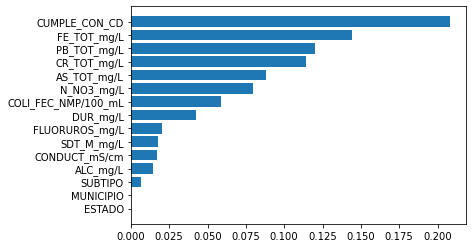

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
tree = DecisionTreeClassifier()

pipeline_DT = Pipeline(steps=[('ct', preprocessor), ('m', tree)])

pipeline_DT.fit(X_train, y_train)
y_hat_dt = pipeline_DT.predict(X_train)
importance = permutation_importance(pipeline_DT, X_train, y_train.values.ravel(), n_repeats=10,random_state=42)
for i,v in enumerate(importance['importances_mean']):
	print('Feature: %s, Score: %.5f' % (X.columns[i],v))

plt.barh(X.columns.to_numpy(), np.sort(importance['importances_mean']))
plt.show()

In [16]:
#import eli5
#from eli5.sklearn import PermutationImportance

#perm = PermutationImportance(pipeline_DT, random_state=1).fit(X_train, y_train)
#eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [17]:
target_names = ['Amarillo', 'Rojo', 'Verde']

In [18]:
print(classification_report(y_train, y_hat_dt, target_names=target_names))

              precision    recall  f1-score   support

    Amarillo       1.00      1.00      1.00       222
        Rojo       1.00      1.00      1.00       349
       Verde       1.00      1.00      1.00       388

    accuracy                           1.00       959
   macro avg       1.00      1.00      1.00       959
weighted avg       1.00      1.00      1.00       959



In [19]:
cm_dt = confusion_matrix(y_train, y_hat_dt)
cm_dt

array([[222,   0,   0],
       [  0, 349,   0],
       [  0,   0, 388]], dtype=int64)

c:\Users\matth\anaconda3\lib\site-packages\sklearn\pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Feature: ESTADO, Score: 0.01429
Feature: MUNICIPIO, Score: 0.01689
Feature: SUBTIPO, Score: 0.00000
Feature: ALC_mg/L, Score: 0.04223
Feature: CONDUCT_mS/cm, Score: 0.05860
Feature: SDT_M_mg/L, Score: 0.00657
Feature: FLUORUROS_mg/L, Score: 0.20792
Feature: DUR_mg/L, Score: 0.14432
Feature: COLI_FEC_NMP/100_mL, Score: 0.07998
Feature: N_NO3_mg/L, Score: 0.12023
Feature: AS_TOT_mg/L, Score: 0.11449
Feature: CR_TOT_mg/L, Score: 0.02044
Feature: PB_TOT_mg/L, Score: 0.01741
Feature: FE_TOT_mg/L, Score: 0.08801
Feature: CUMPLE_CON_CD, Score: 0.00000


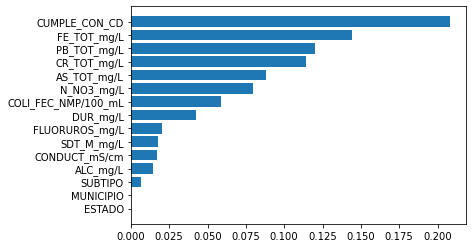

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

tree = RandomForestClassifier(random_state=42,
                              criterion='gini')

pipeline_RF = Pipeline(steps=[('ct', preprocessor), ('m', tree)])

pipeline_RF.fit(X_train, y_train)
y_hat_rf = pipeline_DT.predict(X_train)
importance = permutation_importance(pipeline_DT, X_train, y_train.values.ravel(), n_repeats=10,random_state=42)
for i,v in enumerate(importance['importances_mean']):
	print('Feature: %s, Score: %.5f' % (X.columns[i],v))

plt.barh(X.columns.to_numpy(), np.sort(importance['importances_mean']))
plt.show()

In [21]:
print(classification_report(y_train, y_hat_rf, target_names=target_names))

              precision    recall  f1-score   support

    Amarillo       1.00      1.00      1.00       222
        Rojo       1.00      1.00      1.00       349
       Verde       1.00      1.00      1.00       388

    accuracy                           1.00       959
   macro avg       1.00      1.00      1.00       959
weighted avg       1.00      1.00      1.00       959



In [22]:
cm_rf = confusion_matrix(y_train, y_hat_rf)
cm_rf

array([[222,   0,   0],
       [  0, 349,   0],
       [  0,   0, 388]], dtype=int64)